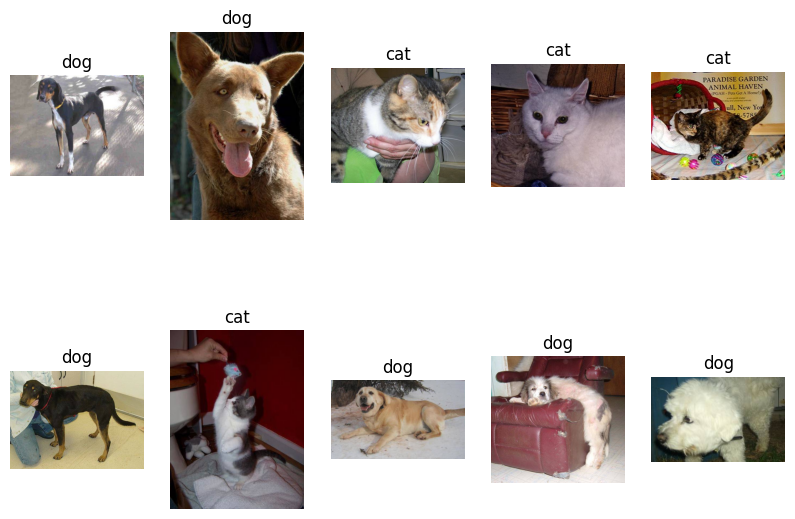

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path

# VS vill inte läsa mina folders utan en relevant path
current_path = Path("C:/Users/lager/Documents/Github/AI-Bjorn-Lagerblad-OPA23")

train_data_path = current_path / "labs/labb2/original_data/train"
test_data_path = current_path / "labs/labb2/original_data/test"

train_list = list(train_data_path.iterdir())
test_list = list(test_data_path.iterdir())

pictures = np.random.choice(train_list, 10, replace=False)

pattern = r"\b\w{3}\b"
labels = [re.findall(pattern, path.name)[0] for path in pictures]

fig, axes = plt.subplots(2, 5, figsize=(10, 7))
for i, ax in enumerate(axes.flatten()):
    image_path = pictures[i] 
    image = plt.imread(image_path) 
    ax.imshow(image)
    ax.set_title(labels[i])
    ax.axis("off")

plt.show()


d) Nu ska du göra train|val|test split med följande splits:

experiment_small
* train - 1600 (800 dogs, 800 cats)
* val - 400 (200 dogs, 200 cats)
* test - 500 (250 dogs, 250 cats)

experiment_tiny (BONUS)
* train - 160 (80 dogs, 80 cats)
* val - 40 (20 dogs, 20 cats)
* test - 50 (25 dogs, 25 cats

In [4]:
import os
import shutil
from pathlib import Path
import numpy as np

base_path = Path('C:/Users/lager/Documents/Github/AI-Bjorn-Lagerblad-OPA23/labs/labb2')

original_train = base_path / 'original_data/train'
small_data = base_path / 'experiment_small_data'
tiny_data = base_path / 'experiment_tiny_data'

splits_small = {
    'train': {'dogs': 800, 'cats': 800},
    'val': {'dogs': 200, 'cats': 200},
    'test': {'dogs': 250, 'cats': 250}
}

splits_tiny = {
    'train': {'dogs': 80, 'cats': 80},
    'val': {'dogs': 20, 'cats': 20},
    'test': {'dogs': 25, 'cats': 25}
}

def sample_and_move_files(source_path, target_path, splits):
    dogs = list(source_path.glob('*dog*'))
    cats = list(source_path.glob('*cat*'))

    for subset, numbers in splits.items():
        if len(dogs) < numbers['dogs']:
            print(f"Warning: Only {len(dogs)} dogs available, requested {numbers['dogs']}")
            sampled_dogs = np.random.choice(dogs, len(dogs), replace=False)  # Adjust number if necessary
        else:
            sampled_dogs = np.random.choice(dogs, numbers['dogs'], replace=False)

        if len(cats) < numbers['cats']:
            print(f"Warning: Only {len(cats)} cats available, requested {numbers['cats']}")
            sampled_cats = np.random.choice(cats, len(cats), replace=False)  # Adjust number if necessary
        else:
            sampled_cats = np.random.choice(cats, numbers['cats'], replace=False)

        for file in sampled_dogs:
            shutil.move(str(file), str(target_path / subset))
        for file in sampled_cats:
            shutil.move(str(file), str(target_path / subset))

        dogs = list(set(dogs) - set(sampled_dogs))
        cats = list(set(cats) - set(sampled_cats))

        if not dogs and numbers['dogs'] > 0:
            print("No more dogs available to sample.")
        if not cats and numbers['cats'] > 0:
            print("No more cats available to sample.")

sample_and_move_files(original_train, small_data, splits_small)

sample_and_move_files(original_train, tiny_data, splits_tiny)


---

 e) Läs in dataseten från experiment_small, experiment_tiny (BONUS) och plocka ut labelsvektorer, som
ska vara one-hot encoded med 0 och 1.
* plotta några bilder med deras respektive labels och kontrollera att det är korrekt.
* skapa lämplig plot för att kontrollera att dataseten är balanserade
* skapa lämplig plot för att kontrollera att dataseten är slumpade

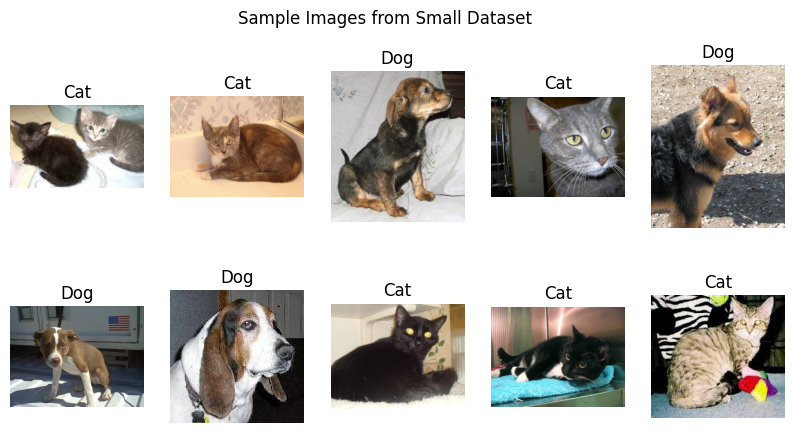

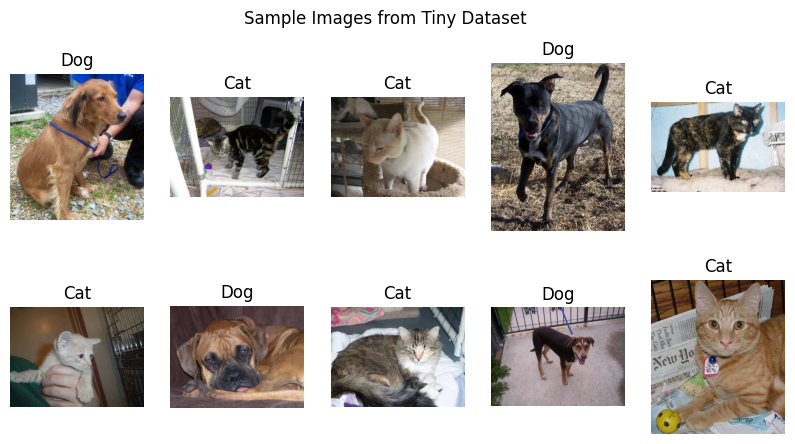

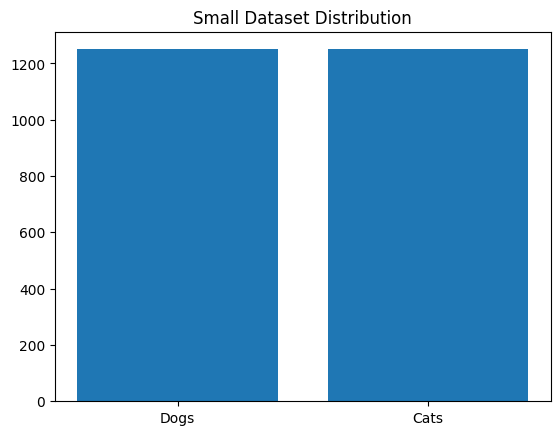

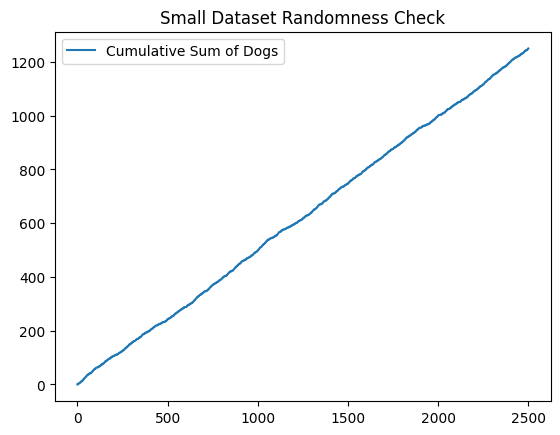

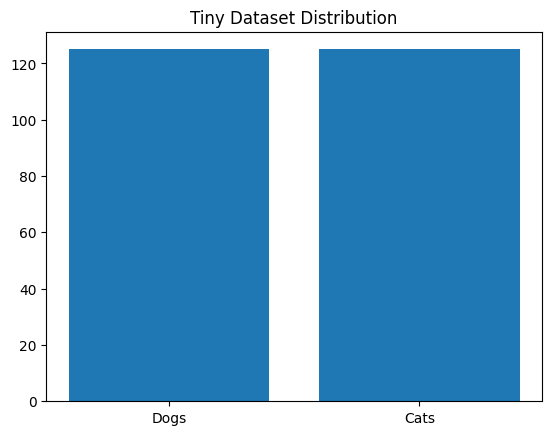

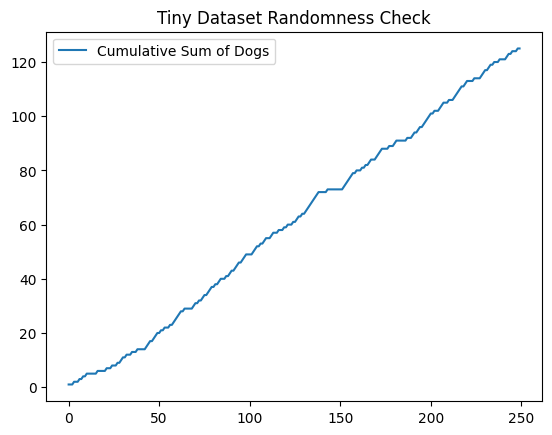

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.preprocessing import LabelBinarizer
from pathlib import Path
import random

base_path = Path("C:/Users/lager/Documents/Github/AI-Bjorn-Lagerblad-OPA23/labs/labb2")
small_data_path = base_path / "experiment_small_data"
tiny_data_path = base_path / "experiment_tiny_data"

def load_data_and_labels(data_path):
    images = []
    labels = []
    for category in ["train", "val", "test"]:
        cat_dir = data_path / category
        files = list(cat_dir.glob("*"))
        random.shuffle(files)  # Shuffle the list to randomize file order
        for image_path in files:
            images.append(imread(str(image_path)))
            file_name = image_path.name.lower()
            if "dog" in file_name:
                labels.append("dog")
            elif "cat" in file_name:
                labels.append("cat")
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    labels = np.array(labels)
    return images, labels, files

images_small, labels_small, files_small = load_data_and_labels(small_data_path)
images_tiny, labels_tiny, files_tiny = load_data_and_labels(tiny_data_path)

def plot_images_with_labels(images, labels, title):
    plt.figure(figsize=(10, 5))
    for i in range(min(10, len(images))):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title("Dog" if labels[i, 0] == 1 else "Cat")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

plot_images_with_labels(images_small, labels_small, "Sample Images from Small Dataset")
plot_images_with_labels(images_tiny, labels_tiny, "Sample Images from Tiny Dataset")

def plot_label_distribution(labels, title):
    dog_count = np.sum(labels[:, 0] == 1)
    cat_count = len(labels) - dog_count
    plt.bar(["Dogs", "Cats"], [dog_count, cat_count])
    plt.title(title + " Distribution")
    plt.show()
    plt.plot(np.cumsum(labels[:, 0]), label="Cumulative Sum of Dogs")
    plt.title(title + " Randomness Check")
    plt.legend()
    plt.show()

plot_label_distribution(labels_small, "Small Dataset")
plot_label_distribution(labels_tiny, "Tiny Dataset")
